# Analyse mechanochem - only from elongation scenario

We assume that at $Wi \gg 1$, the growth of the longest segment in the chain is only a function of accumulated strain. Since the tension in that segment should scale with the strain rate, we conclude that the distribution of maximum tensions, hence the portion of broken chains, is only a function of $\varepsilon$ and $\dot\varepsilon$.


In [1]:
import numpy as np
from matsindy.feature_library import FeatureLibrary

from ipywidgets import interactive, fixed
import ipywidgets as widgets
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8]

## Datasets selection

In [2]:
Wi_max = 1000                       # Peak Weissenberg number in simulations
n_links = 1000                      # Number of segments in the Kramers chain
n_ensemble = 1000                     # Number of molecules to simulate

# Input folder
data_folder = 'outputs/Kramers'
                    
scenario = 'elongation_0'
with np.load(f"{data_folder}/{scenario}_Wi{Wi_max}_nlinks{n_links}_nmol{n_ensemble}.npz") as data:
    temp = dict(data)
    # Rename and normalise variables
    tau = 0.0142*n_links**2
    temp['A'] = temp.pop('A_average')/n_links**2
    temp['∇U'] = temp.pop('gradU')*tau
    temp['t'] = temp['t']/tau
    dgradU = np.zeros_like(temp['∇U'])
    dgradU[1:] = np.diff(temp['∇U'], axis=0)/np.diff(temp['t'])[:, None, None]
    temp['d∇U'] = dgradU
    temp['tr(Ad∇U)'] = np.trace(temp['A']@temp['d∇U'], axis1=1, axis2=2)
    # Add transposed variables
    temp['∇Uᵀ'] = np.transpose(temp['∇U'], axes=(0, 2, 1))
    # Principal strain rates
    temp['epsilon_dot'] = np.linalg.eigvalsh(0.5*(temp['∇U'] + temp['∇Uᵀ']))

    # Add features
    temp['tr(A)'] = np.trace(temp['A'], axis1=1, axis2=2)
    temp['tr(A∇U)'] = np.trace(temp['A']@temp['∇U'], axis1=1, axis2=2)
    # temp['tr(A∇U∇Uᵀ)'] = np.trace(temp['A']@temp['∇U']@temp['∇Uᵀ'], axis1=1, axis2=2)

    # Effective principal strain rate
    temp['w'] = temp['tr(A∇U)']/temp['tr(A)']

    # Estimates of the Henky strain, one using principal strain rates, the other using polymer extension
    h = np.zeros_like(temp['t'])
    h_prime = np.zeros_like(temp['t'])
    for i, dt in enumerate(np.diff(temp['t'])):
        h[i+1] = (np.amax(temp['epsilon_dot'][i]) + h[i]/dt)/(1./dt + 1./1.)
        h_prime[i+1] = (temp['tr(A∇U)'][i]/temp['tr(A)'][i] + h_prime[i]/dt)/(1./dt + 1./1.)
    temp['h'] = h
    temp['h_prime'] = h_prime

    # Effective square segment
    temp['L2'] = temp['g_max']/temp['epsilon_dot'][:,2]
    temp['M2'] = temp['g_12']/temp['epsilon_dot'][:,2]


# Save
data = temp

## Plot effective segments

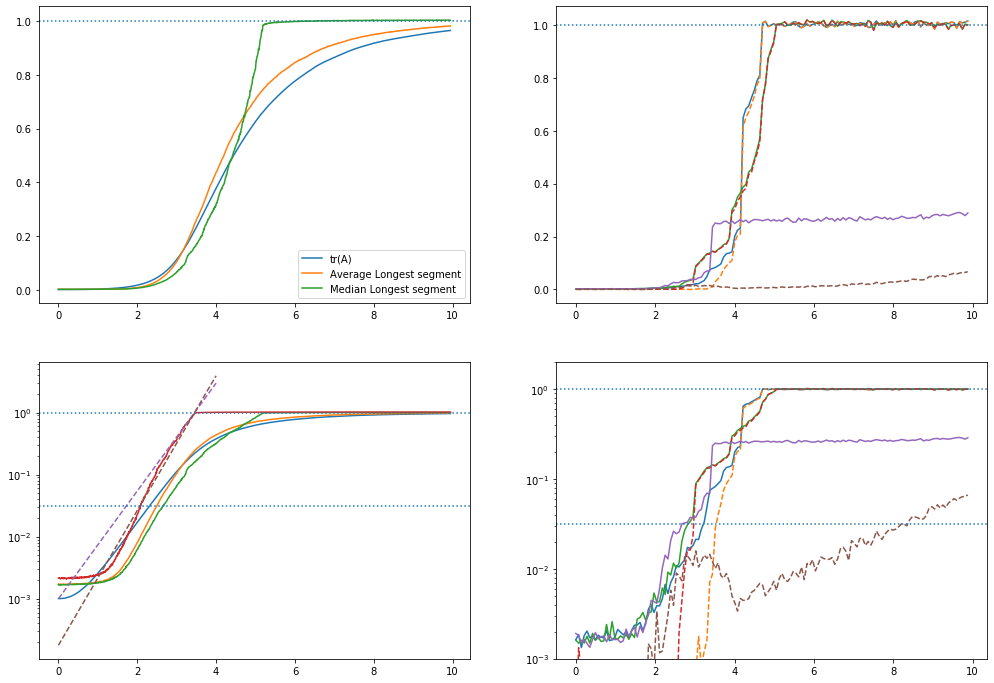

In [38]:
plt.rcParams['figure.figsize'] = [17, 12]
fig, ax = plt.subplots(ncols=2, nrows=2)
ax[0,0].plot(data['h'], data['tr(A)'], label='tr(A)')
ax[0,0].plot(data['h'], np.average(data['L2'], axis=0)*0.0142*8, label='Average Longest segment')
ax[0,0].plot(data['h'], np.median(data['L2'], axis=0)*0.0142*8, label='Median Longest segment')
ax[0,0].axhline(1, ls=':')
ax[0,0].legend()

for i in range(3):
    ax[0,1].plot(data['h'][::10], data['L2'][i,::10]*0.0142*8)
    ax[0,1].plot(data['h'][::10], data['M2'][i,::10]*0.0142*8, '--')
    
ax[0,1].axhline(1, ls=':')

ax[1,0].semilogy(data['h'], data['tr(A)'])
ax[1,0].semilogy(data['h'], np.average(data['L2'], axis=0)*0.0142*8)
ax[1,0].semilogy(data['h'], np.median(data['L2'], axis=0)*0.0142*8)
ax[1,0].semilogy(data['h'], np.percentile(data['L2'], 97, axis=0)*0.0142*8)
x = np.linspace(0,4)
ax[1,0].semilogy(x, np.exp(2*x -np.log(n_links)), '--')
ax[1,0].semilogy(x, np.exp(2.5*x -2.5/2*np.log(n_links)), '--')

ax[1,0].axhline(1, ls=':')
ax[1,0].axhline(1/n_links**0.5, ls=':')

for i in range(3):
    ax[1,1].semilogy(data['h'][::10], data['L2'][i,::10]*0.0142*8)
    ax[1,1].semilogy(data['h'][::10], data['M2'][i,::10]*0.0142*8, '--')
    
ax[1,1].set_ylim(1/n_links, 2)
ax[1,1].axhline(1, ls=':')
ax[1,1].axhline(1/n_links**0.5, ls=':')

Onset of scission is likely to be with affine stretching, $e^{2h}=N$, therefore $h=\log(N)/2$. If scission occurs before full extension, 

### Effective segment for mechanophore activation

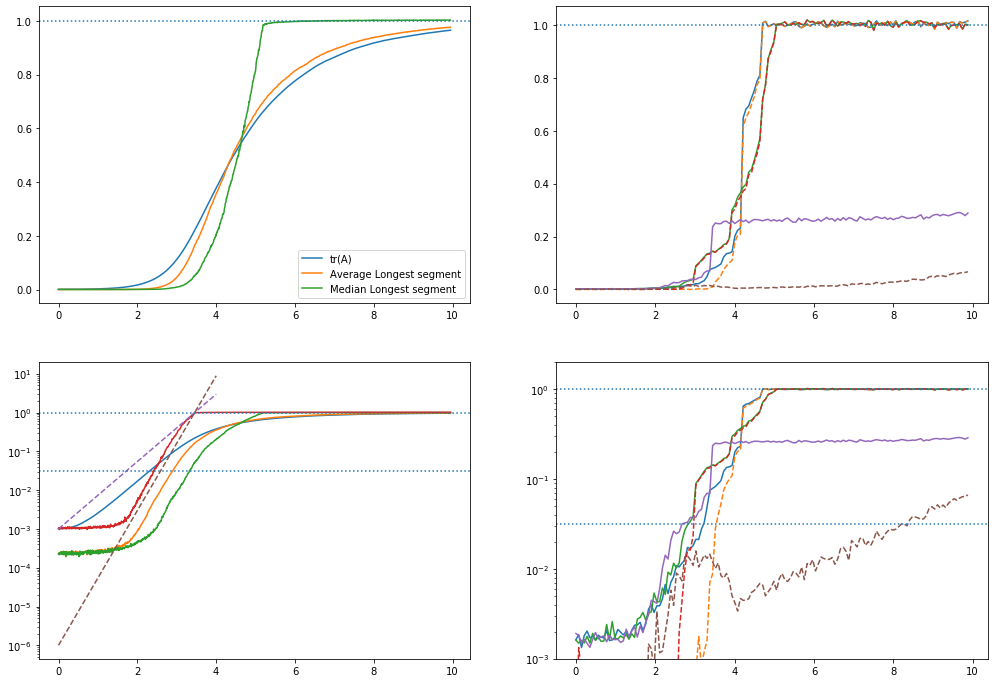

In [41]:
plt.rcParams['figure.figsize'] = [17, 12]
fig, ax = plt.subplots(ncols=2, nrows=2)
ax[0,0].plot(data['h'], data['tr(A)'], label='tr(A)')
ax[0,0].plot(data['h'], np.average(data['M2'], axis=0)*0.0142*8, label='Average Longest segment')
ax[0,0].plot(data['h'], np.median(data['M2'], axis=0)*0.0142*8, label='Median Longest segment')
ax[0,0].axhline(1, ls=':')
ax[0,0].legend()

for i in range(3):
    ax[0,1].plot(data['h'][::10], data['L2'][i,::10]*0.0142*8)
    ax[0,1].plot(data['h'][::10], data['M2'][i,::10]*0.0142*8, '--')
    
ax[0,1].axhline(1, ls=':')

ax[1,0].semilogy(data['h'], data['tr(A)'])
ax[1,0].semilogy(data['h'], np.average(data['M2'], axis=0)*0.0142*8)
ax[1,0].semilogy(data['h'], np.median(data['M2'], axis=0)*0.0142*8)
ax[1,0].semilogy(data['h'], np.percentile(data['M2'], 97, axis=0)*0.0142*8)
x = np.linspace(0,4)
ax[1,0].semilogy(x, np.exp(2*x -np.log(n_links)), '--')
ax[1,0].semilogy(x, np.exp(4*x -4./2*np.log(n_links)), '--')

ax[1,0].axhline(1, ls=':')
ax[1,0].axhline(1/n_links**0.5, ls=':')

for i in range(3):
    ax[1,1].semilogy(data['h'][::10], data['L2'][i,::10]*0.0142*8)
    ax[1,1].semilogy(data['h'][::10], data['M2'][i,::10]*0.0142*8, '--')
    
ax[1,1].set_ylim(1/n_links, 2)
ax[1,1].axhline(1, ls=':')
ax[1,1].axhline(1/n_links**0.5, ls=':')

## Simulate mechanophore activation and scission at constant strain rate

For an elongated chain, the maximum tension is at the centre and given by:
$$
g_\max = Wi\left(\frac{N^2}{8} + \frac{N}{2} \right)
$$
So a critical tension corresponds to a critical Weissenberg number
$$
Wi_c = \frac{g_c}{\frac{N^2}{8} + \frac{N}{2}}
$$
And there is a critical Wi for mechanophore activation: $Wi_m$

1760.5633802816901 880.2816901408451


Text(0.5, 1.0, 'Mechanophore activation')

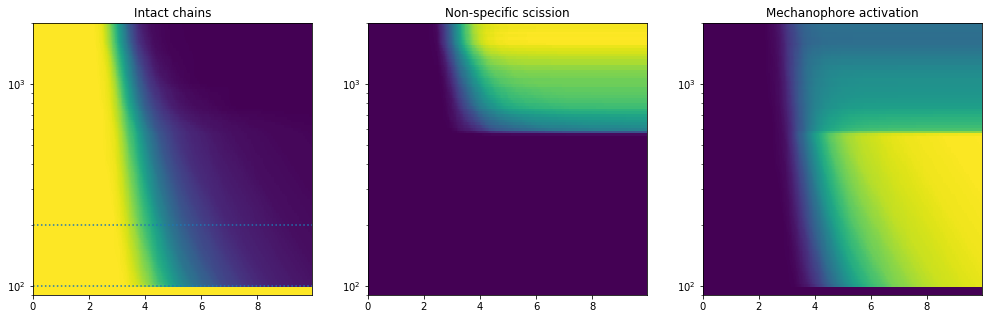

In [4]:
Wi_c = 200
Wi_m = 100
threshold = Wi_c/(8*0.0142)
mechanophore = Wi_m/(8*0.0142)
print(threshold, mechanophore)


cs = []
c_scissions = []
c_mechanophores = []

# Tensions are going to be rescaled with Wi
Wis = np.logspace(np.log10(0.9*Wi_m),np.log10(Wi_c)+1,100)

for Wi in Wis:

    scission_events = np.zeros_like(data['t'])
    mechanophore_events = np.zeros_like(data['t'])
    for tension_max, tension_centre in zip(Wi*data['L2'], Wi*data['M2']):
        for i, (g_max, g_12) in enumerate(zip(tension_max, tension_centre)):
            
            if g_max > threshold and g_12 < mechanophore:
                # Non-specific scission
                scission_events[i] += 1
                break
            if g_12 > mechanophore and g_max < threshold:
                # mechanophore activation
                mechanophore_events[i] += 1
                break
                
            if g_12 > mechanophore and g_max > threshold: # and g_12==g_max:
                # both events
                mechanophore_events[i] += 1
                break
                
#            if g_12 > mechanophore and g_max > threshold and g_12 != g_max:
#                # both events
#                if np.random.rand() > 0.5:
#                    mechanophore_events[i] += 1
#                else:
#                    scission_events[i] += 1
#                break
                
    data['c_scission'] = np.cumsum(scission_events)/n_ensemble
    data['c_mechanophore'] = np.cumsum(mechanophore_events)/n_ensemble
    data['c'] = 1. - (data['c_scission'] + data['c_mechanophore'])
    cs.append(data['c'])
    c_scissions.append(data['c_scission'])
    c_mechanophores.append(data['c_mechanophore'])

cs = np.array(cs)
c_scissions = np.array(c_scissions)
c_mechanophores = np.array(c_mechanophores)
#c_array[c_array==1] = np.nan
#c_array[c_array==0] = np.nan

plt.rcParams['figure.figsize'] = [17, 5]
fig, ax = plt.subplots(ncols=3)
ax[0].pcolormesh(data['h'], Wis, cs)
ax[0].axhline(Wi_c, ls=':')
ax[0].axhline(Wi_m, ls=':')
ax[0].set_yscale('log')
ax[0].set_title('Intact chains')

ax[1].pcolormesh(data['h'], Wis, c_scissions)
ax[1].set_yscale('log')
ax[1].set_title('Non-specific scission')

ax[2].pcolormesh(data['h'], Wis, c_mechanophores)
ax[2].set_yscale('log')
ax[2].set_title('Mechanophore activation')
#plt.plot(data['h_prime'],110*np.exp(-4*data['h_prime']))
#plt.plot(data['h_prime'],110*np.exp(-4*(data['h_prime']))+1, 'r:')
#plt.plot(data['h_prime'],100*np.exp(-2*(data['h_prime']-0.8))+1, 'r:')


Inspect the result:

## Simulate at constant strain

In [5]:
print(data['L2'].shape)

strain_cs = np.zeros_like(cs)
strain_c_scissions = np.zeros_like(c_scissions)
strain_c_mechanophores = np.zeros_like(c_mechanophores)


for j, (L2s, M2s) in enumerate(zip(data['L2'].T, data['M2'].T)):
    
    scission_events = np.zeros_like(Wis)
    mechanophore_events = np.zeros_like(Wis)
    
    for tension_max, tension_centre in zip(np.outer(L2s, Wis), np.outer(M2s, Wis)):

        
        for i, (g_max, g_12) in enumerate(zip(tension_max, tension_centre)):

            if g_max > threshold and g_12 < mechanophore:
                # Non-specific scission
                scission_events[i] += 1
                break
            if g_12 > mechanophore and g_max < threshold:
                # mechanophore activation
                mechanophore_events[i] += 1
                break

            if g_12 > mechanophore and g_max > threshold and g_12==g_max:
                # both events
                mechanophore_events[i] += 1
                break

            if g_12 > mechanophore and g_max > threshold and g_12 != g_max:
                # both events
                if np.random.rand() > 0.5:
                    mechanophore_events[i] += 1
                else:
                    scission_events[i] += 1
                break
                
    strain_c_scissions[:, j] = np.cumsum(scission_events)/n_ensemble
    strain_c_mechanophores[:, j] = np.cumsum(mechanophore_events)/n_ensemble
    strain_cs[:, j] = 1. - (strain_c_scissions[:, j] + strain_c_mechanophores[:, j])

(1000, 1420)


Text(0.5, 1.0, 'Mechanophore activation')

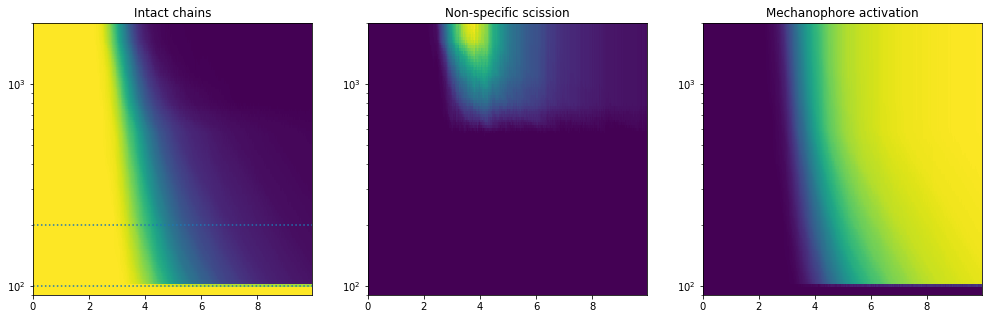

In [6]:
plt.rcParams['figure.figsize'] = [17, 5]
fig, ax = plt.subplots(ncols=3)
ax[0].pcolormesh(data['h'], Wis, strain_cs)
ax[0].axhline(Wi_c, ls=':')
ax[0].axhline(Wi_m, ls=':')
ax[0].set_yscale('log')
ax[0].set_title('Intact chains')

ax[1].pcolormesh(data['h'], Wis, strain_c_scissions)
ax[1].set_yscale('log')
ax[1].set_title('Non-specific scission')

ax[2].pcolormesh(data['h'], Wis, strain_c_mechanophores)
ax[2].set_yscale('log')
ax[2].set_title('Mechanophore activation')

## Intact chains is independent of the path taken

They correspond to the population for which both $g_{1/2} < g_m$ and $g_{max} < g_c$.

In [16]:
intact_chains = np.outer(Wis, data['h'])
# Differential tables
dw_to_scission = np.zeros_like(intact_chains)
dw_to_mechanophore = np.zeros_like(intact_chains)
dh_to_scission = np.zeros_like(intact_chains)
dh_to_mechanophore = np.zeros_like(intact_chains)

for i, Wi in enumerate(Wis):
    for j, h in enumerate(data['h']):
        # Distributions
        tension_maxs, tension_centres = Wi*data['L2'][:,j], Wi*data['M2'][:,j]
        # Conditional distribution
        T = (tension_maxs < threshold) * (tension_centres < mechanophore)
        intact_chains[i, j] = np.sum(T)/n_ensemble
        
        i_step = 3
        if i < len(Wis)-i_step:
            # From this point, we increase Wi
            T_dw = tension_centres[T]/Wi*Wis[i+i_step] > mechanophore
            dw_to_mechanophore[i, j] = np.sum(T_dw)/n_ensemble

            T_dw = (tension_maxs[T]/Wi*Wis[i+i_step] > threshold) * (tension_centres[T]/Wi*Wis[i+i_step] < mechanophore)
            dw_to_scission[i, j] = np.sum(T_dw)/n_ensemble
        
        j_step = 30
        if j < len(data['h']) - j_step:
            # Or we increase h
            tension_maxs2, tension_centres2 = Wi*data['L2'][:,j+j_step], Wi*data['M2'][:,j+j_step]
            T_dh = tension_centres2[T] > mechanophore
            dh_to_mechanophore[i, j] = np.sum(T_dh)/n_ensemble

            T_dh = (tension_maxs2[T] > threshold) * (tension_centres2[T] < mechanophore)
            dh_to_scission[i, j] = np.sum(T_dh)/n_ensemble

Text(0.5, 1.0, 'Mechanophore activation with strain')

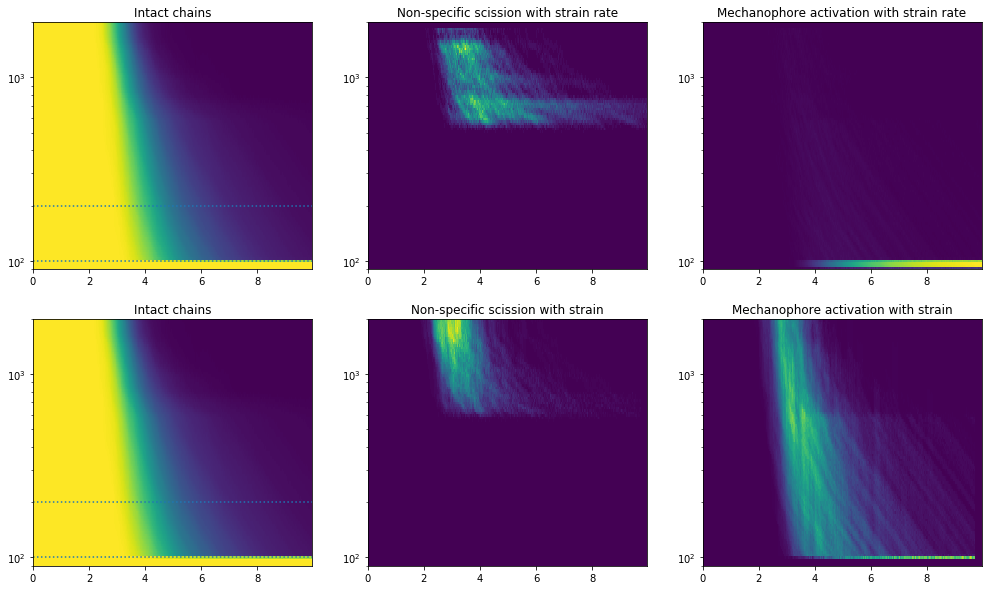

In [17]:
plt.rcParams['figure.figsize'] = [17, 10]
fig, ax = plt.subplots(ncols=3, nrows=2)
ax[0,0].pcolormesh(data['h'], Wis, intact_chains)
ax[0,0].axhline(Wi_c, ls=':')
ax[0,0].axhline(Wi_m, ls=':')
ax[0,0].set_yscale('log')
ax[0,0].set_title('Intact chains')

ax[0,1].pcolormesh(data['h'], Wis, dw_to_scission)
ax[0,1].set_yscale('log')
ax[0,1].set_title('Non-specific scission with strain rate')

ax[0,2].pcolormesh(data['h'], Wis, dw_to_mechanophore)
ax[0,2].set_yscale('log')
ax[0,2].set_title('Mechanophore activation with strain rate')

ax[1,0].pcolormesh(data['h'], Wis, intact_chains)
ax[1,0].axhline(Wi_c, ls=':')
ax[1,0].axhline(Wi_m, ls=':')
ax[1,0].set_yscale('log')
ax[1,0].set_title('Intact chains')

ax[1,1].pcolormesh(data['h'], Wis, dh_to_scission)
ax[1,1].set_yscale('log')
ax[1,1].set_title('Non-specific scission with strain')

ax[1,2].pcolormesh(data['h'], Wis, dh_to_mechanophore)
ax[1,2].set_yscale('log')
ax[1,2].set_title('Mechanophore activation with strain')

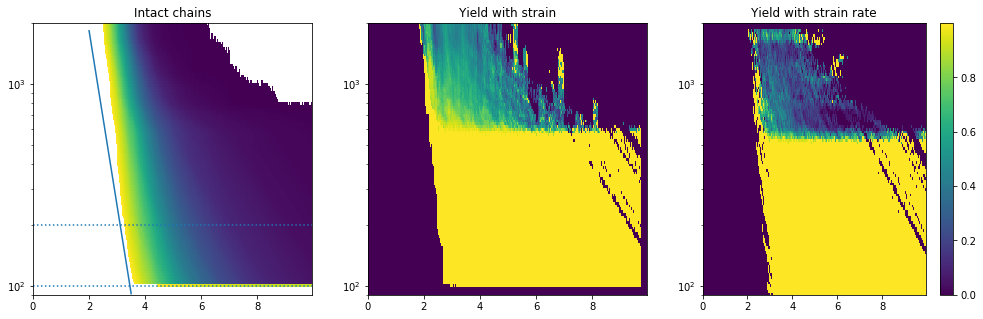

In [48]:
yield_dh = dh_to_mechanophore/(dh_to_mechanophore + dh_to_scission + 1e-6)
yield_dw = dw_to_mechanophore/(dw_to_mechanophore + dw_to_scission + 1e-6)
intact_chains_clear = intact_chains.copy()
intact_chains_clear[intact_chains_clear>0.95] = np.nan
intact_chains_clear[intact_chains_clear==0] = np.nan

plt.rcParams['figure.figsize'] = [17, 5]
fig, ax = plt.subplots(ncols=3)
ax[0].pcolormesh(data['h'], Wis, intact_chains_clear)
ax[0].axhline(Wi_c, ls=':')
ax[0].axhline(Wi_m, ls=':')
x = np.linspace(2,3.5)
ax[0].plot(x, Wi_m*np.exp(-2*(x-np.log(n_links)/2)))
ax[0].set_yscale('log')
ax[0].set_title('Intact chains')

ax[1].pcolormesh(data['h'], Wis, yield_dh)
ax[1].set_yscale('log')
ax[1].set_title('Yield with strain')

cf = ax[2].pcolormesh(data['h'], Wis, yield_dw)
ax[2].set_yscale('log')
ax[2].set_title('Yield with strain rate')
fig.colorbar(cf)

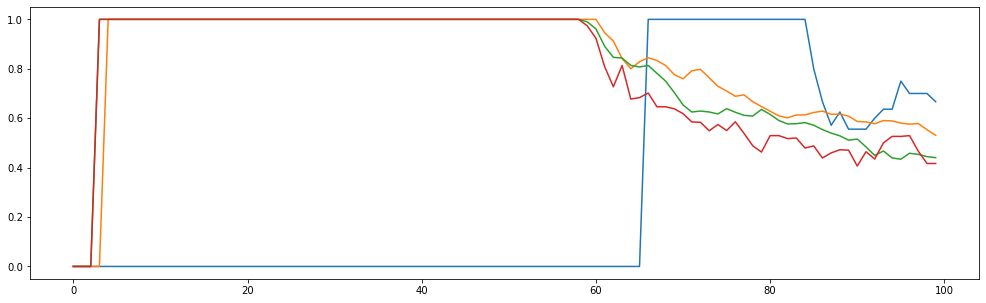

In [10]:
plt.plot(yield_dh[:,300])
plt.plot(yield_dh[:,400])
plt.plot(yield_dh[:,500])
plt.plot(yield_dh[:,600])

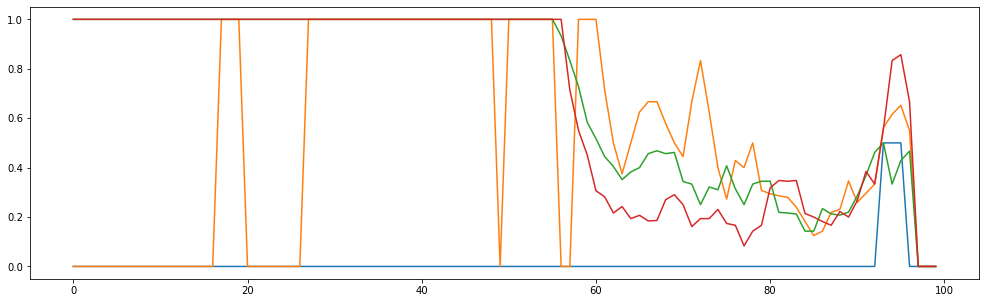

In [11]:
plt.plot(yield_dw[:,300])
plt.plot(yield_dw[:,400])
plt.plot(yield_dw[:,500])
plt.plot(yield_dw[:,600])

We see that an increase of strain rate is responsible for an almost constant 10% activation, while we have from 40%-50% from an increase in strain. 100% of reacting chain at low strain and strain rate activate mechanophore.

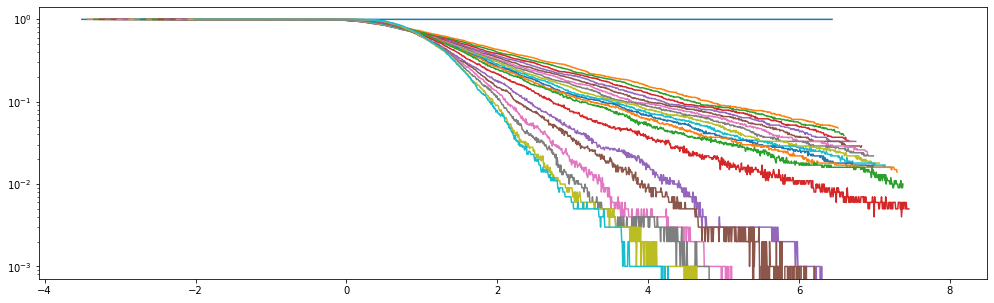

In [51]:
for curve, Wi in zip(intact_chains[::5], Wis[::5]):
    plt.semilogy(data['h']-(np.log(n_links)/2-np.log(Wi/Wi_m)/2), curve)

In [30]:
np.log(1000)/2

3.4538776394910684